<h1 style="text-align: center;"> Commodity & Exchange Prices </p>

##### NOTE: Plots are Commodities Data, comments & insights are copied from Google Mobility

## Table of contents
1. [Problem Domain](#Problem-Domain)
2. [Required Libraries](#Required-Libraries)
3. [Google Mobility Data](#Google-Mobililty-Data)
4. [Data Exploration](#Data-Exploration)
5. [Visualizations](#Visualizations)
6. [Resampling](#Resampling)<br>
7. [Decomposition](#Decomposition)
8. [Time Series Stationarity](#Time-Series-Stationarity)
9. [Making Time Series Stationary](#Making-Time-Series-Stationary)
10. [Autocorrelations and Partial Autocorrelations](#Autocorrelations-and-Partial-Autocorrelations)
11. [ARIMA Modeling](#ARIMA-Modeling)
12. [Conclusion](#Conclusion)

## Problem Domain

[[ go back to the top ]](#Table-of-contents)

In this notebook, time-series processing methods are applied for forecasting oil stock performance as part of the requirements of the RMDS 2021 Data Science Competition. Here, the *Google COVID-19 Community Mobility Reports* are leveraged to generate insights with time series modeling. We have just over one year of daily mobility data, measured as the percent change from established baseline values.

"2020 saw the collapse of crude oil prices as demand disappeared due to the global economic shutdown that paralyzed the world's economies. Oil prices fell more than 90% as the industry was plagued with overproduction and disappearing demand. On April 20, the May contract for WTI futures fell below zero for the first time, the day before the contract expired." - [*Investopedia*](https://www.investopedia.com/terms/w/wti.asp)

## Required Libraries

[[ go back to the top ]](#Table-of-contents)

This notebook uses several Python libraries such as:

In [153]:
# Load required packages 
import datetime
from datetime import timedelta
import numpy as np
import pandas as pd

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns

# Time-Series
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
from scipy import signal
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

<a id='Commodity-Data'></a>

## Commodity & Exchange Price Data

[[ go back to the top ]](#Table-of-contents)

This dataset contains just over a year's worth of daily-frequency data from six sub-categories ("Indicators") in the United States. A total of 382 records, aggregated across county and state levels, were collected from 2020-02-15 to 2021-03-02 (YYYY-MM-DD). Each mobility indicator is measured as percent change from baseline.

From the official documentation website ([source](https://www.google.com/covid19/mobility/data_documentation.html?hl=en)):

Baseline

*    The median value, for the corresponding day of the week, during the 5-week period Jan 3–Feb 6, 2020.

**Commodity & Exchange Indicators**

|Indicator|Data Type|Dataset|Region-Frequency|Description|
|---|---|---|---|---|
|**Brent Crude Oil**|*float*|Commodity Prices|Daily|Price, in USD per barrel, of North Sea Brent crude oil as traded on the Intercontinental Exchange(ICE).|
|**WTI Crude Oil**|*float*|Commodity Prices|Daily|Price, in USD per barrel, of West Texas Intermediate(WTI) crude oil, the underlying commodity of the NYMSEX. It is the main oil benchmark for North America.|
|**Settlement Price**|*float*|Commodity & Exchange|Daily|Price of final transaction on a futures exchange for a given "trading" day.|
|**Open Interest**|*int*|Commodity & Exchange|Daily|Number of outstanding contracts(positions held) in the derivatives market. Open interest is an indicator of liquidity as each futures contract is for 100 shares.|

#### Load Data

In [154]:
# Load Data Function
def LOAD_DATA(filepath, filename):
    # Read CSV files
    if filename.endswith('.csv'):
        new_df = pd.read_csv(filepath+filename)

    # Read Excel files
    elif filename.endswith('.xlsx'):
        new_df = pd.read_excel(filepath+filename)
    print(type(new_df.index))
    if type(new_df.index) != pd.core.indexes.datetimes.DatetimeIndex:
        for col in new_df.columns:
            if col.lower().find('date') != -1:
                print(f"TIMESTAMP FOUND! '{col}'")
                print()
                new_df['date'] = pd.to_datetime(new_df[col]) # format = '%Y/%m/%d'
#                new_df.set_index('date', inplace = True)
                # If datetime col was already == 'date', no need to drop col after set_index, otherwise...
                if col != 'date':
                    new_df.drop(columns = col, inplace = True)
                
    # Try to identify the date column
    elif type(new_df.index) == pd.core.indexes.datetimes.DatetimeIndex:
        print('Index already in datetime')
        
    display(new_df.info())
    return new_df

In [155]:
## Originally we wanted to include the Brent crude oil futures but 
## because the cross-market holiday schedules ICE-data created NaN's
## Only the NYMEX data is included and WTI crude oil (USD per barrel)
#filepath = '../../data/Financial_Market/'
#filename = 'commodity_prices.xlsx'
#df = LOAD_DATA(filepath, filename)
#
## Remove ICE data with problematic holiday schedule
#nymex_df = df[(df['Commodity And Exchange'] == 'NYMEX CRUDE OIL FUTURES') |
#   (df['Commodity And Exchange'] == 'WTI CRUDE OIL (DOLLARS PER BARREL)') ]
#nymex_df
#
## See dictionary for definitions of indicators selected for the model
#nymex_df = nymex_df[(nymex_df['Indicator'] == 'SETTLE') |
#                    (nymex_df['Indicator'] == 'PRICE IN USD') |
#                    (nymex_df['Indicator'] == 'PREVIOUS DAY OPEN INTEREST') ]
#
## List of select categories to include in model within a given col
#nymex_indicators = list(nymex_df.Indicator.value_counts().index)
#count = 0
#for indicator in nymex_indicators:
#    # Trim redundant substrings with last_char
#    last_char = len(indicator)
#    
#    # Remove casing and extra white space
#    #formatted_name = indicator[:last_char][count].strip().lower()
#    formatted_name = indicator[:last_char].strip().lower()
#    
#    # Temporary DataFrame 'df_i' of just one indicator (DJCA, DJIA, DJTA, DJUA, etc.)
#    df_i = nymex_df[nymex_df['Indicator']==indicator].copy()
#    
#    #df_i['date'] = df_i['Date Value']
#    df_i = df_i.groupby(['date'], as_index=True).mean()
#    
#    # Replace default 'Value' with descriptive col name
#    df_i.rename(columns = {'Value': formatted_name.replace(" ", "_")}, inplace = True)
#    df_i.rename(columns = {'Value': formatted_name.replace(" ", "_")}, inplace = True)
#    if count == 0:
#        df_0 = df_i.copy()
#    else:
#        df_0 = pd.concat([df_0, df_i], axis =1)
#    count += 1
#    
## Check that all is copacetic
#display(round(df_0, 2))
#
## Look at the mismatched dates due to holiday conflicts
#df_0[df_0.isnull().any(axis=1)]

In [156]:
# Filtered data from WorldData.AI, with most recent week's dates
filepath = '../../data/Financial_Market/'
filename = 'commodities.csv'
df = LOAD_DATA(filepath, filename)

<class 'pandas.core.indexes.range.RangeIndex'>
TIMESTAMP FOUND! 'Date Value'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27937 entries, 0 to 27936
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Sub-Sector              27937 non-null  object        
 1   Super Region            27937 non-null  object        
 2   Sector                  27937 non-null  object        
 3   Commodity And Exchange  27937 non-null  object        
 4   Frequency               27937 non-null  object        
 5   Source                  27937 non-null  object        
 6   Indicator               27937 non-null  object        
 7   Super Region.1          27937 non-null  object        
 8   Value                   27937 non-null  float64       
 9   Period Value            27937 non-null  object        
 10  date                    27937 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float6

None

In [157]:
def drop_columns(dataframe):
    redund_dict = {}
    df = dataframe
    # Drop redundant columns and store redundant data more efficiently
    for col in df:
        # Identify columns with only one value repeated on every row
        value_counts = df[col].value_counts().count()
        # Reduce DataFrame if any columns contain only one value
        if value_counts == 1:
            k = col # keys
            v = df[col].value_counts().index[0] # values
            # Store redundant data in a dictionary
            redund_dict.update({k : v})
            # Drop redundant data columns
            df.drop(columns=[col], inplace = True)
    return df
drop_columns(df)

,Commodity And Exchange,Indicator,Value,date
0,WTI CRUDE OIL (DOLLARS PER BARREL),PRICE IN USD,65.03,2021-03-08
1,WTI CRUDE OIL (DOLLARS PER BARREL),PRICE IN USD,66.08,2021-03-05
2,WTI CRUDE OIL (DOLLARS PER BARREL),PRICE IN USD,63.81,2021-03-04
3,WTI CRUDE OIL (DOLLARS PER BARREL),PRICE IN USD,61.33,2021-03-03
4,WTI CRUDE OIL (DOLLARS PER BARREL),PRICE IN USD,59.70,2021-03-02
...,...,...,...,...
27932,NYMEX CRUDE OIL FUTURES,SETTLE,29.90,1983-04-06
27933,NYMEX CRUDE OIL FUTURES,SETTLE,29.71,1983-04-05
27934,NYMEX CRUDE OIL FUTURES,SETTLE,29.44,1983-04-04
27935,NYMEX CRUDE OIL FUTURES,SETTLE,29.29,1983-03-31


#### Add Calculated Columns

Some important metrics can be calculated and included in the modeling.

In [158]:
#df['new_column'] = df.column1 - df.column2
#df.head()

## Data Exploration

[[ go back to the top ]](#Table-of-contents)

In [159]:
nymex_df['Commodity And Exchange'].value_counts()

NYMEX CRUDE OIL FUTURES               2000
WTI CRUDE OIL (DOLLARS PER BARREL)    1000
Name: Commodity And Exchange, dtype: int64

In [160]:
nymex_df.Indicator.value_counts()

SETTLE                        1000
PREVIOUS DAY OPEN INTEREST    1000
PRICE IN USD                  1000
Name: Indicator, dtype: int64

In [161]:
df.groupby(['Commodity And Exchange', 'Indicator']).describe()

Value  \
                                                                count   
Commodity And Exchange             Indicator                            
NYMEX CRUDE OIL FUTURES            PREVIOUS DAY OPEN INTEREST  9532.0   
                                   SETTLE                      9540.0   
WTI CRUDE OIL (DOLLARS PER BARREL) PRICE IN USD                8865.0   

                                                                              \
                                                                        mean   
Commodity And Exchange             Indicator                                   
NYMEX CRUDE OIL FUTURES            PREVIOUS DAY OPEN INTEREST  154263.691565   
                                   SETTLE                          43.140407   
WTI CRUDE OIL (DOLLARS PER BARREL) PRICE IN USD                    44.077973   

                                                                              \
                                                                         std   
Commodity And Exchange             Indicator                                   
NYMEX CRUDE OIL FUTURES            PREVIOUS DAY OPEN INTEREST  139551.980330   
                                   SETTLE                          28.038786   
WTI CRUDE OIL (DOLLARS PER BARREL) PRICE IN USD                    28.812711   

                                                                      \
                                                                 min   
Commodity And Exchange             Indicator                           
NYMEX CRUDE OIL FUTURES            PREVIOUS DAY OPEN INTEREST  64.00   
                                   SETTLE                     -37.63   
WTI CRUDE OIL (DOLLARS PER BARREL) PRICE IN USD               -36.98   

                                                                         \
                                                                    25%   
Commodity And Exchange             Indicator                              
NYMEX CRUDE OIL FUTURES            PREVIOUS DAY OPEN INTEREST  52075.75   
                                   SETTLE                         20.11   
WTI CRUDE OIL (DOLLARS PER BARREL) PRICE IN USD                   19.80   

                                                                          \
                                                                     50%   
Commodity And Exchange             Indicator                               
NYMEX CRUDE OIL FUTURES            PREVIOUS DAY OPEN INTEREST  99671.500   
                                   SETTLE                         30.525   
WTI CRUDE OIL (DOLLARS PER BARREL) PRICE IN USD                   32.010   

                                                                            \
                                                                       75%   
Commodity And Exchange             Indicator                                 
NYMEX CRUDE OIL FUTURES            PREVIOUS DAY OPEN INTEREST  239065.7500   
                                   SETTLE                          60.6325   
WTI CRUDE OIL (DOLLARS PER BARREL) PRICE IN USD                    62.5100   

                                                                          
                                                                     max  
Commodity And Exchange             Indicator                              
NYMEX CRUDE OIL FUTURES            PREVIOUS DAY OPEN INTEREST  642793.00  
                                   SETTLE                         145.29  
WTI CRUDE OIL (DOLLARS PER BARREL) PRICE IN USD                   145.31

In [162]:
# List of select categories to include in model within a given col
indicators = list(df.Indicator.value_counts().index)
count = 0
for indicator in indicators:
    # Trim redundant substrings with last_char
    last_char = len(indicator)
    
    # Remove casing and extra white space
    #formatted_name = indicator[:last_char][count].strip().lower()
    formatted_name = indicator[:last_char].strip().lower()
    
    # Temporary DataFrame 'df_i' of just one indicator (DJCA, DJIA, DJTA, DJUA, etc.)
    df_i = df[df['Indicator']==indicator].copy()
    
    #df_i['date'] = df_i['Date Value']
    df_i = df_i.groupby(['date'], as_index=True).mean()
    
    # Replace default 'Value' with descriptive col name
    df_i.rename(columns = {'Value': formatted_name.replace(" ", "_")}, inplace = True)
    df_i.rename(columns = {'Value': formatted_name.replace(" ", "_")}, inplace = True)
    if count == 0:
        df_0 = df_i.copy()
    else:
        df_0 = pd.concat([df_0, df_i], axis =1)
    count += 1
    
# Check that all is copacetic
display(round(df_0, 2))

,settle,previous_day_open_interest,price_in_usd
date,,,
1983-03-30,29.40,470.0,NaN
1983-03-31,29.29,523.0,NaN
1983-04-04,29.44,583.0,NaN
1983-04-05,29.71,623.0,NaN
1983-04-06,29.90,640.0,NaN
...,...,...,...
2021-03-10,64.44,245616.0,NaN
2021-03-11,66.02,215531.0,NaN
2021-03-12,65.61,198494.0,NaN


In [163]:
#https://stackoverflow.com/questions/41513324/python-pandas-drop-rows-of-a-timeserie-based-on-time-range
# Select meaningful date range
start_remove = pd.to_datetime('2017-3-8')
end_remove = pd.to_datetime('2021-3-5')
df_0 = df_0.loc[(df_0.index >= start_remove) & (df_0.index <= end_remove)]

In [164]:
# notice all these NaN's in WTI Crude Oil price per barrel
# These correspond to American holidays and will correspond to closing stock price data
df_0[df_0.isnull().any(axis=1)].sort_index()

,settle,previous_day_open_interest,price_in_usd
date,,,
2017-07-03,47.07,517659.0,NaN
2018-11-23,50.42,433772.0,NaN
2018-12-24,42.53,391671.0,NaN
2018-12-31,45.41,387024.0,NaN
2019-07-05,57.51,299915.0,NaN
2019-11-11,56.86,317237.0,NaN
2020-11-27,45.53,407847.0,NaN


In [165]:
# Renname df_0
#crude_df = df_0.copy()
crude_df.isnull().sum()

Value                     0
Commodity And Exchange    0
date                      0
dtype: int64

> *Observations*
>
> Notice: We do not have to deal with missing values. However, all mobility indicators seems to have tailed off extreme values. 

## Visualizations

[[ go back to the top ]](#Table-of-contents)

In [166]:
plt.rcParams["figure.figsize"] = (20,20)
plt.style.use('seaborn')

In [178]:
series.name

'settle'

In [179]:
nbins

50

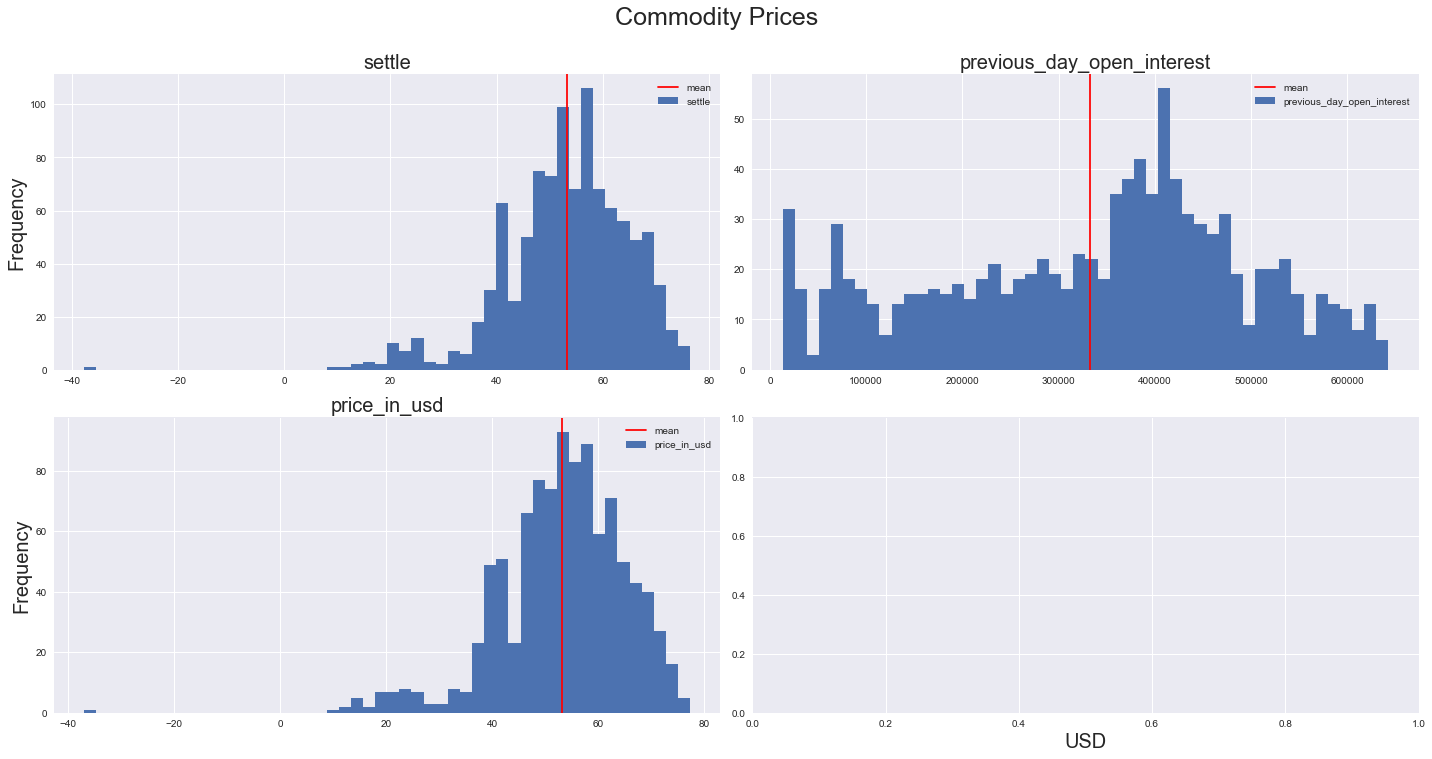

In [185]:
df = df_0.copy()
nrows, ncols, nbins = 2, 2, 50

fig, ax = plt.subplots(nrows, ncols, figsize=(20,10))
count, label_size = 0, 20
col_list = list(df.columns)

for row in range(nrows):
    for col in range(ncols):
        # To manage an odd number of subplots
        if (row == nrows-1) & (col == ncols-1):
            break
        series = df[col_list[count]]
        ax[row][col].hist(series, bins = nbins, label=series.name)
        ax[row][col].set_title(col_list[count], fontsize = label_size)
        ax[row][col].axvline(x=series.mean(), color= 'r', label = 'mean')
        ax[row][col].legend()
        count+=1
    ax[row][0].set_ylabel('Frequency', fontsize = label_size)   
ax[1][1].set_xlabel('USD', fontsize = label_size)
plt.suptitle('Commodity Prices', y = 1.05, fontsize = label_size+5)
plt.tight_layout()

> *Observations*
>
> By plotting the histogram of mobility, we can see the characteristic distribution of each indicator.
> - Mobility trends around workplaces are predominantly negative indicating lower mobility relaitive to the baseline, and seem to center around minus 20%. There are also scattered values between -80 to -40 percent-change that require further cleaning/investigation for interpretation.
> - Mobility around places of retail, restaurants, and recreation contain many extreme low values which may pose problems in downstream analysis. 
> - Mobility trends around parks and places of residence seem to be mostly positive with two overlapping peaks in parks. 
> - Mobility around markets and drug stores seem to be centered around 0% change (in contrast to all other indicators), however, both ends seems to have scattered extreme values that may require further investigation.

### Look at a Zoomed-In Window

In [ ]:
df.info()

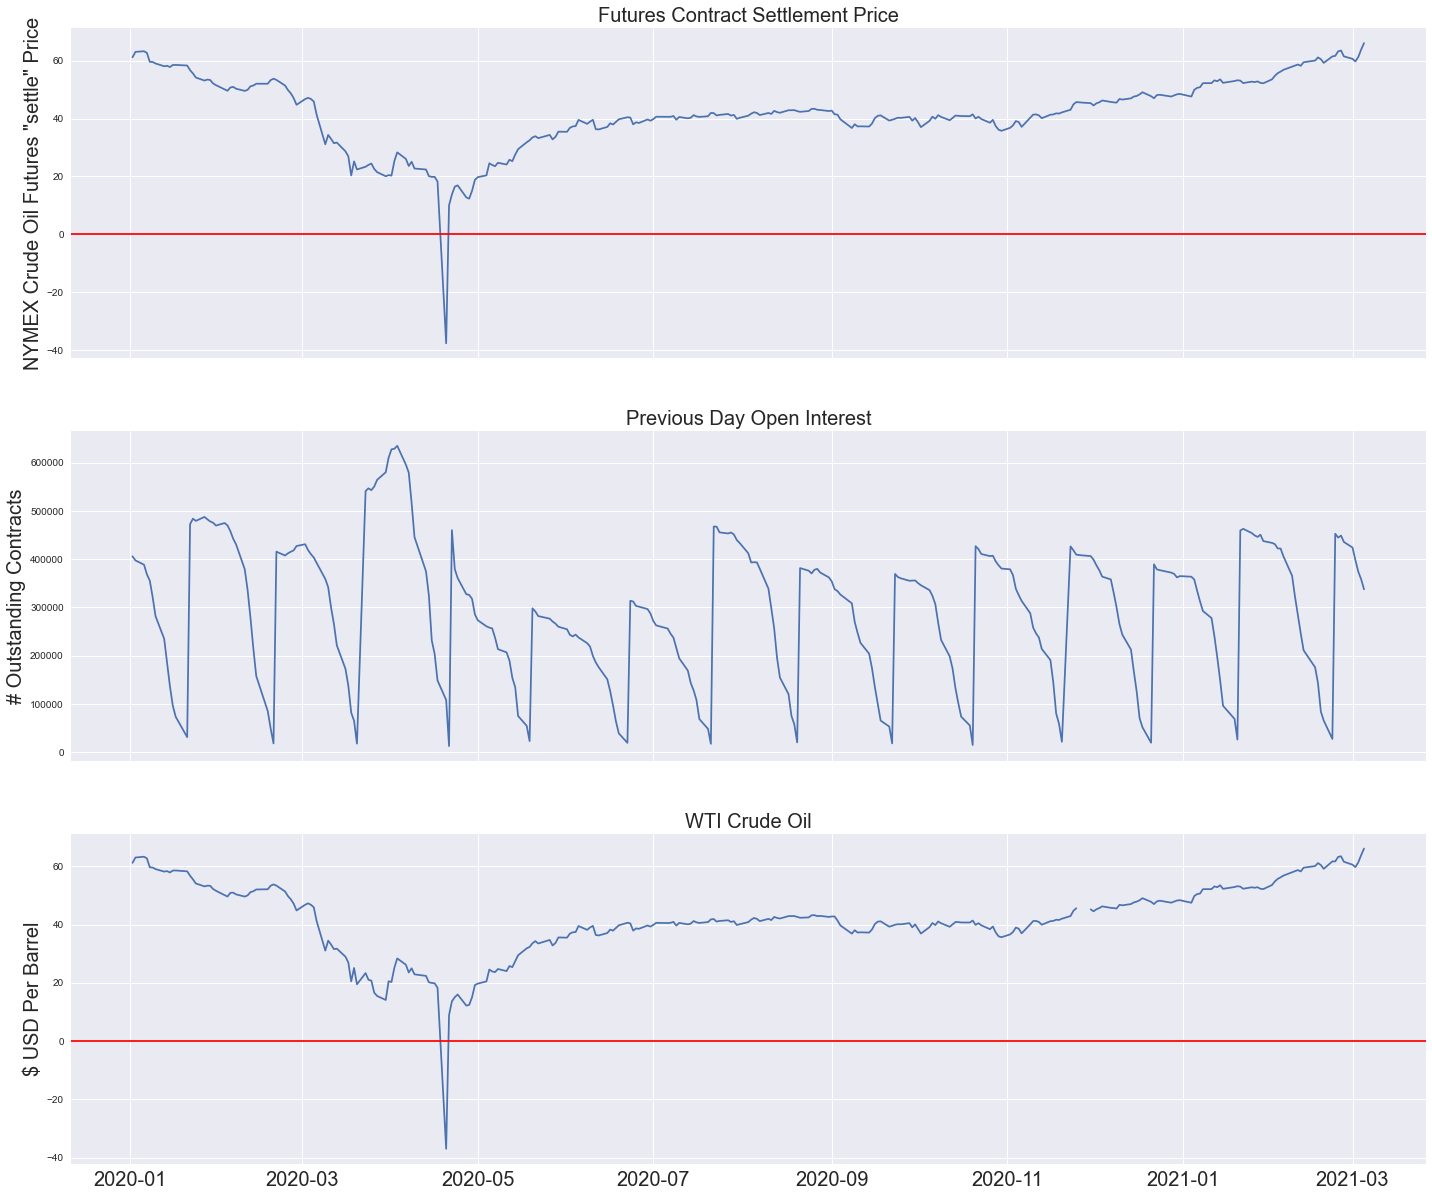

In [204]:
nrows, ncols = 3, 1
fig, ax = plt.subplots(nrows, ncols, figsize=(20,17), squeeze=False, sharex=True)

# Titles
labelz = []
labelz.append('Futures Contract Settlement Price')
labelz.append('Previous Day Open Interest')
labelz.append('WTI Crude Oil')
labely.append('NYMEX Crude Oil Settle')
labely.append('# Outstanding Contracts')
labely.append('$ USD Per Barrel')

# Choose range of interest
start = '2020-01-01'
end = '2021-03-08'
count, label_size = 0, 20
col_list = list(df.columns)

for row in range(nrows):
    for col in range(ncols):
        series = df.loc[start:end, col_list[count]]
        ax[row][col].plot(series)
        #ax[row][col].set_title(col_list[count].upper(), fontsize = label_size)
        ax[row][col].set_title(labelz[row], fontsize = label_size)
        count+=1
    ax[row][0].set_ylabel(labely[row], fontsize = label_size)
    #ax[row][0].title(labelz[row], fontsize = label_size)
    if (row == 0) | (row == nrows-1):
        ax[row][col].axhline(y=0, color= 'r', label = 'mean')


plt.xticks(fontsize =label_size)
plt.tight_layout()

> *Observations*
> 
> When zoomed into the "holiday season", we can see the relationship between the mobility trends more clearly. The peaks in residential data show the private celebrations held by Americans around Thanksgiving, Christmas, and the New Year. These are the %-changes compared to a non-holiday baseline so it is expected that all other indicators would display a downward spiking mobility trend. Distinct cyclic behavior in workplace mobility is evident weekly, and appears to correspond with dips in residential mobility. This could be an indication of data-seasonality which will hinder series stationarity if left untreated.
>
> "2020 saw the collapse of crude oil prices as demand disappeared due to the global economic shutdown that paralyzed the world's economies. Oil prices fell more than 90% as the industry was plagued with overproduction and disappearing demand. On April 20, the May contract for WTI futures fell below zero for the first time, the day before the contract expired." - [*Investopedia*](https://www.investopedia.com/terms/w/wti.asp)

### Look at the Entire Data

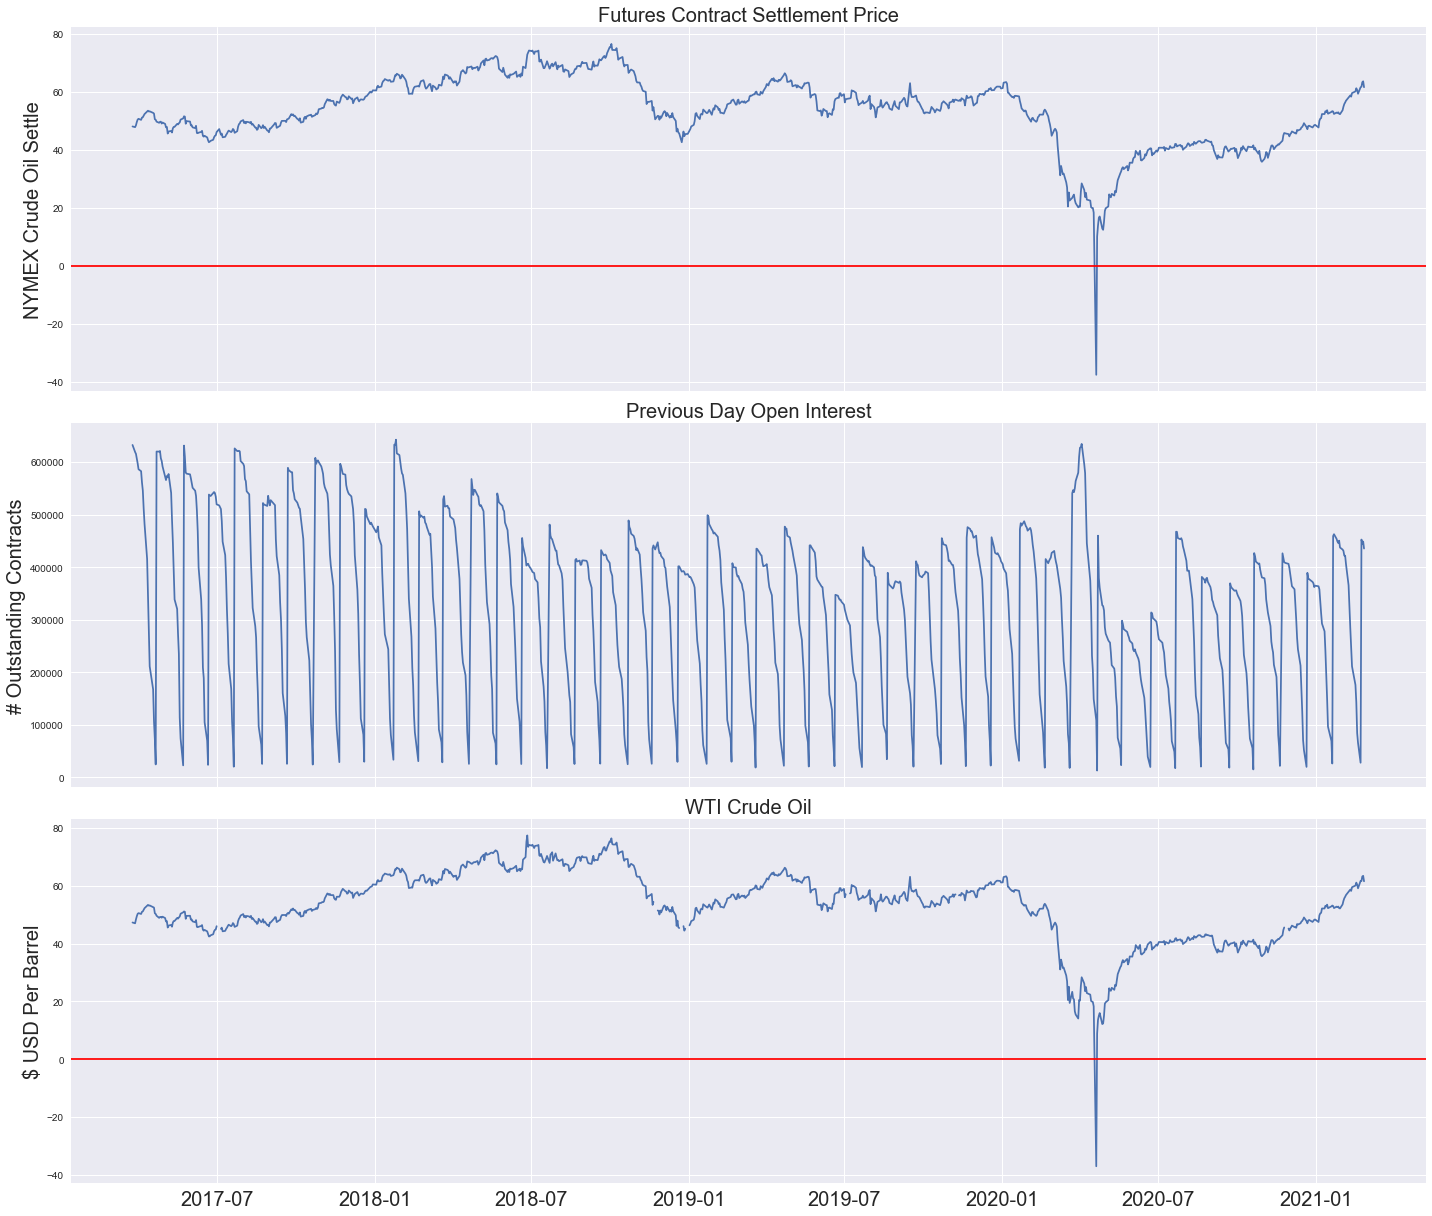

In [208]:
#nrows, ncols = 3, 1
fig, ax = plt.subplots(nrows = 3,
                       ncols = 1,
                       figsize=(20,17), 
                       squeeze=False, # Make it all fit
                       sharex=True, # Make toggle switch
                       sharey=False) # Make User Input and toggle

# Titles
labelz = []
labelz.append('Futures Contract Settlement Price')
labelz.append('Previous Day Open Interest')
labelz.append('WTI Crude Oil')

labely = []
labely.append('NYMEX Crude Oil Settle')
labely.append('# Outstanding Contracts')
labely.append('$ USD Per Barrel')

# Choose range of interest
start = '2017-03-24'
end = '2021-02-26'
count, label_size = 0, 20
col_list = list(df.columns)

for row in range(nrows):
    for col in range(ncols):
        series = df.loc[start:end, col_list[count]]
        ax[row][col].plot(series)
        #ax[row][col].set_title(col_list[count].upper(), fontsize = label_size)
        ax[row][col].set_title(labelz[row], fontsize = label_size)
        count+=1
    ax[row][0].set_ylabel(labely[row], fontsize = label_size)
    #ax[row][0].set_ylabel('Index Value', fontsize = label_size)
    if (row == 0) | (row == nrows-1):
        ax[row][col].axhline(y=0, color= 'r', label = 'mean')
        plt.xticks(fontsize =label_size)
plt.tight_layout()

> *Observations*
>
> A full year's worth of daily data is too condensed. Although some significant impacts such as national holidays and government enforced shutdowns can be identified, it's quite difficult to obtain actionable insights from the entire dataset. Big-picture insights can be extracted from subtle variations in the data after further processing.


## Resampling

[[ go back to the top ]](#Table-of-contents)

In [209]:
def resample_rolling(data = df, d = 7, f = 'W'):
    # Figsize probably needs to be generalized to remove hardcoded dimensions
    fig, axs = plt.subplots(nrows = 2,
                            ncols = 1,
                            sharex= True,
                            sharey=True,
                            figsize=(14,8))
    days = d
    freq = f
    df_0 = data
    
    # Resample
    df_m = df_0.resample(freq).mean()
    # Rolling mean: Mean of a moving window across time periods, smoothing
    df_rm = df_0.rolling(days).mean()
    
    #sns.lineplot(data = df_0, ax = axs[0]);
    sns.lineplot(data = df_m, ax = axs[0], legend = False);
    
    #sns.lineplot(data = df_0, ax = axs[1]);
    sns.lineplot(data= df_rm, ax = axs[1], legend = 'full');
    
    plt.suptitle('Indicator Index Value', fontsize = label_size)
    #axs[0].xticks(fontsize =label_size), plt.yticks(fontsize =label_size)
    #axs[0].get_legend().remove()
    axs[1].legend(fontsize = 13,
                  #loc='best',
                  bbox_to_anchor=(0.5, 0.6, 0.5, 0.1)) # (x, y, width, height)
    plt.tight_layout()
    return

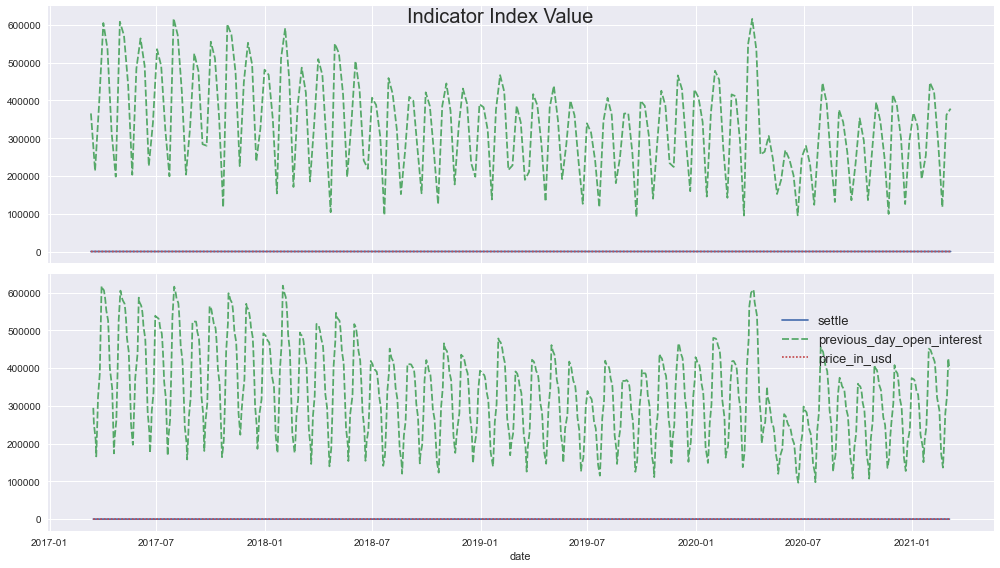

In [210]:
# Default is 7-days (one week = 'W')
resample_rolling()

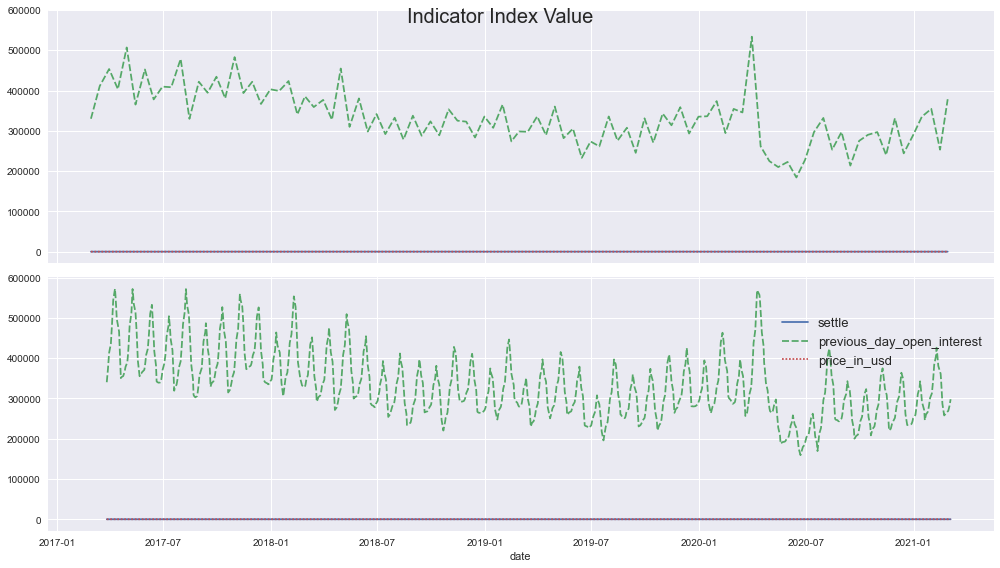

In [211]:
resample_rolling(d=14, f='SM')

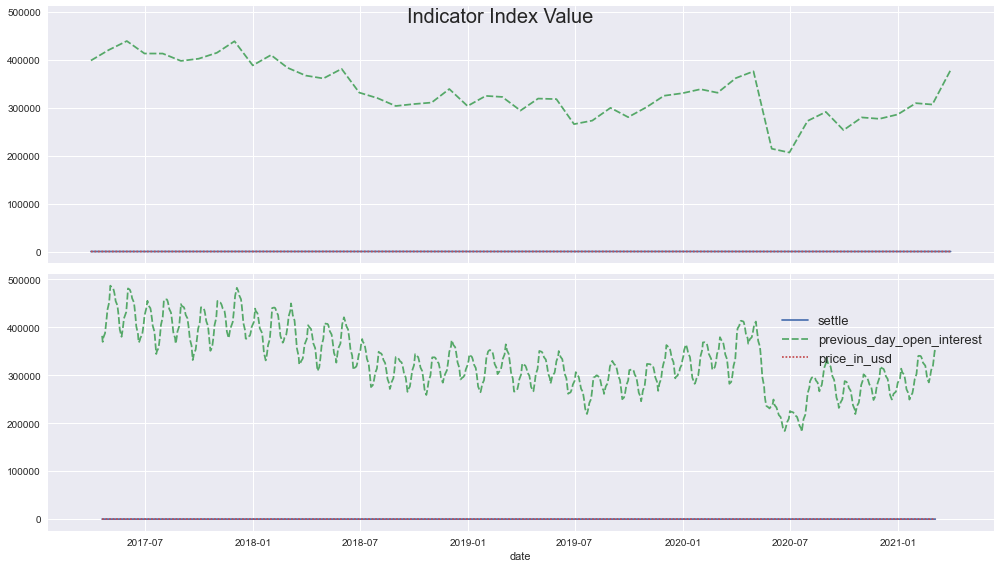

In [212]:
resample_rolling(d=30, f='M');

> *Observations*
>
> We can clearly see a downward trend in parks mobility when the winter months bring less favorable outdoor weather. Currently, it can be seen that all mobility indicators are converging together slightly lower than this time last year except, notably, residential mobility trends remain steadily around 10% higher. This visualization allows us to quickly identify intervals for close inspection, aiding in an abnormality analysis.
>
> **The rest of the analysis, will focus on working with the resampled mobility data**

In [213]:
#resample_rolling(d=90, f='Q')
#resample_rolling(d=180, f='BA')
#resample_rolling(d=365, f='Y')
freq = 'W'
df_r = df.resample(freq).mean()

The data will be subset up until 2020-08-08 where the mobility was relative stable for model building and analysis. The latter part of the data shows sharp spikes that may be result of government shutdowns, holidays, etc. which might not suitable for time-series modeling.

## Decomposition

[[ go back to the top ]](#Table-of-contents)

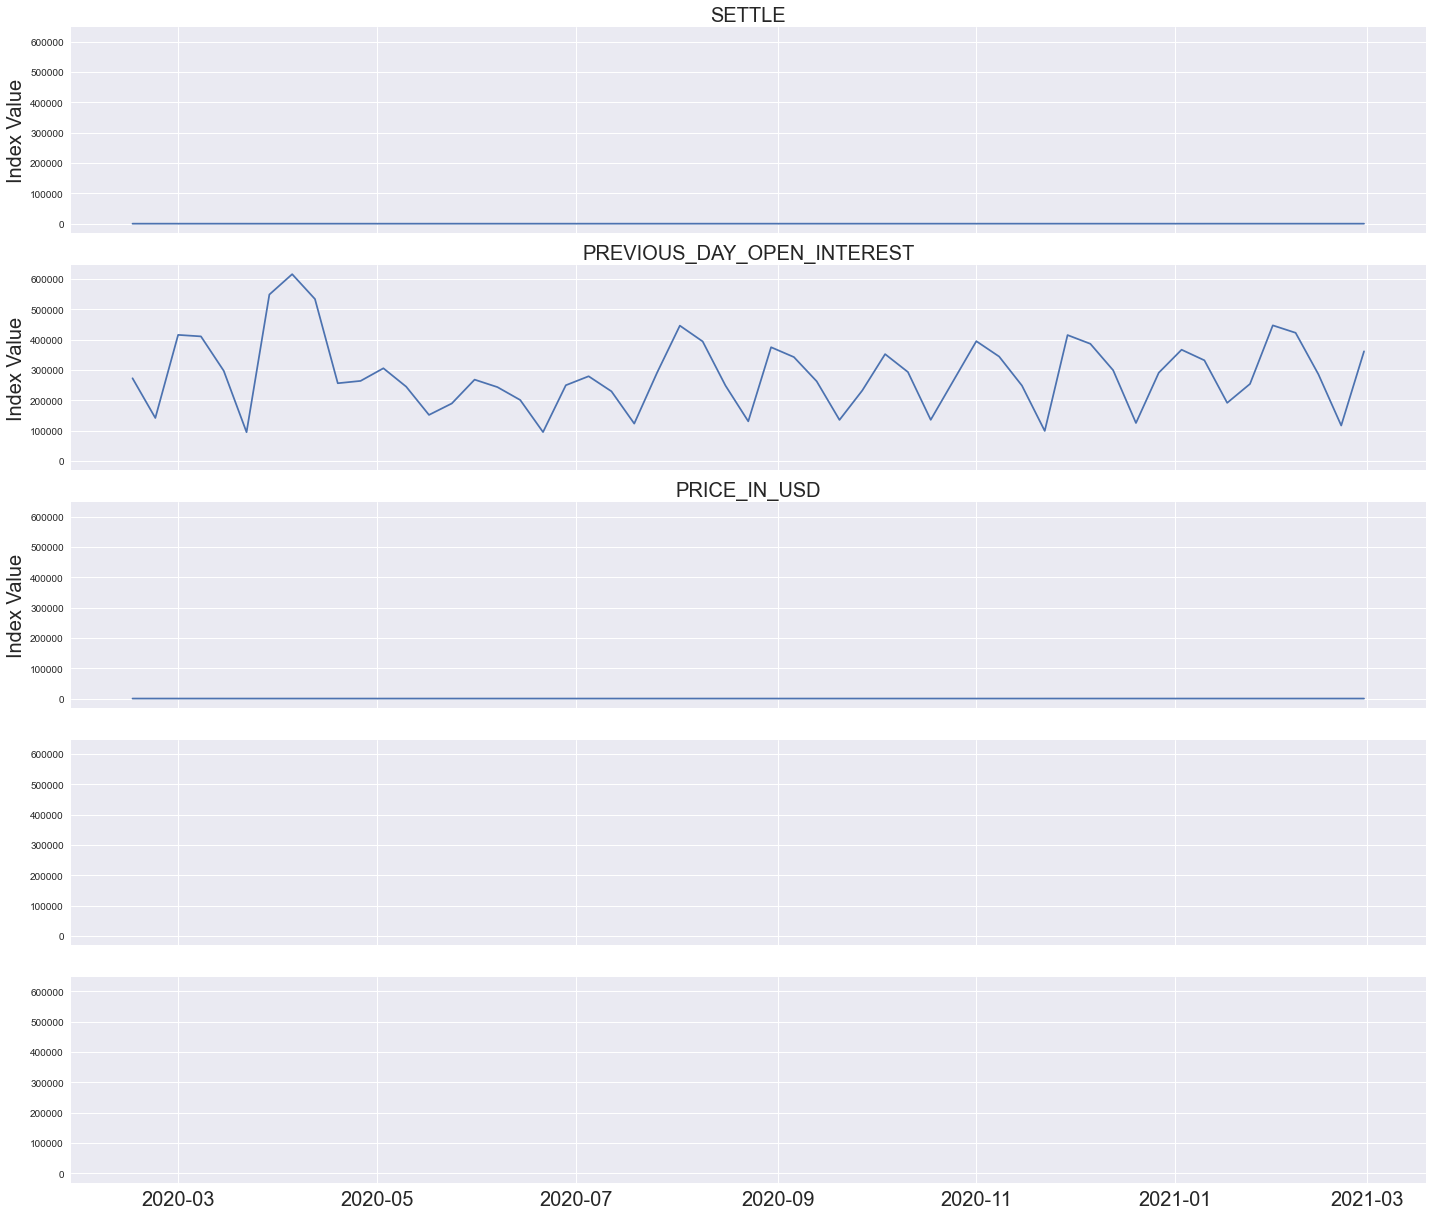

In [214]:
fig, ax = plt.subplots(nrows = 5,
                       ncols = 1,
                       figsize=(20,17),
                       squeeze=False,
                       sharey = True,
                       sharex=True)

# Choose time-series subset(date range of interest)
start = '2020-02-15' # '2020-02-15' first date
end = '2021-03-02'
count, label_size = 0, 20
col_list = list(df.columns)

for row in range(nrows):
    for col in range(ncols):
        series = df_r.loc[start:end, col_list[count]]
        ax[row][col].plot(series)
        ax[row][col].set_title(col_list[count].upper(), fontsize = label_size)
        count+=1
    ax[row][0].set_ylabel('Index Value', fontsize = label_size)
plt.xticks(fontsize =label_size)
plt.tight_layout()

ValueError: This function does not handle missing values

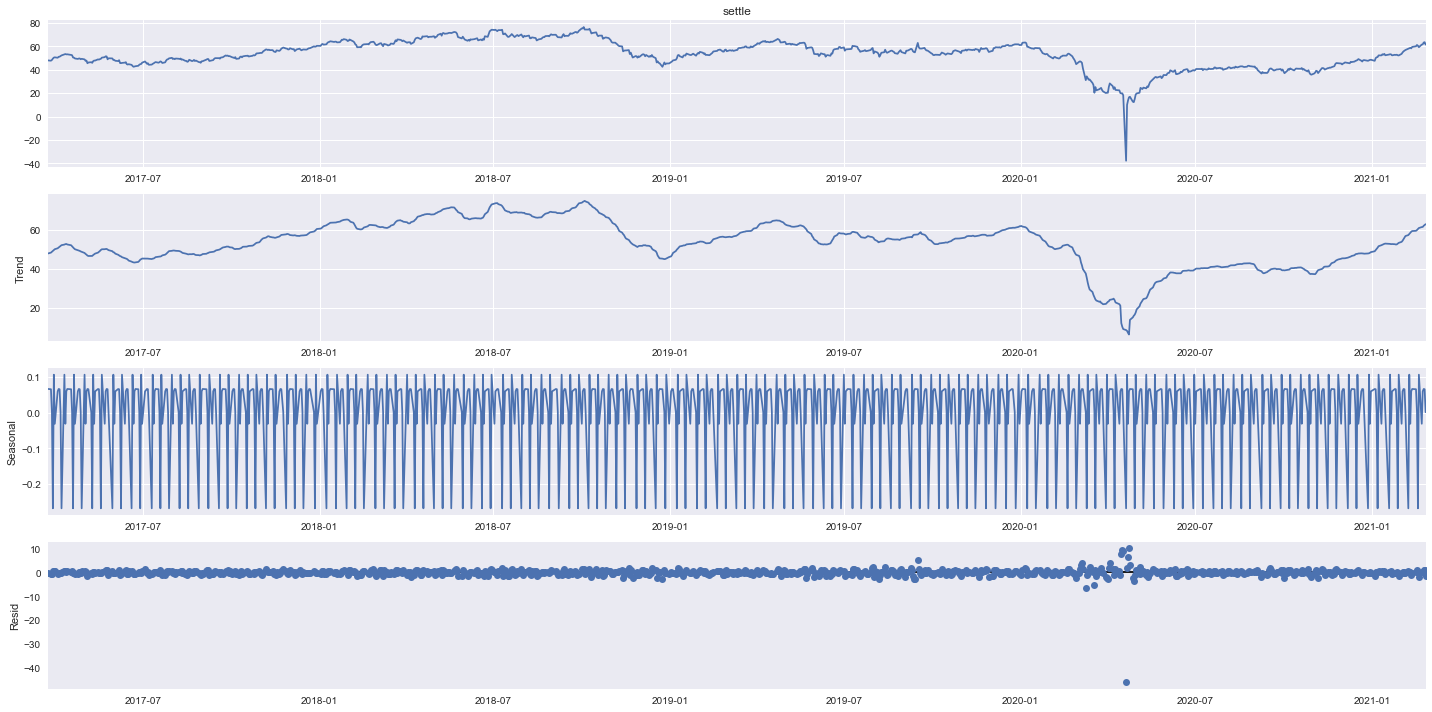

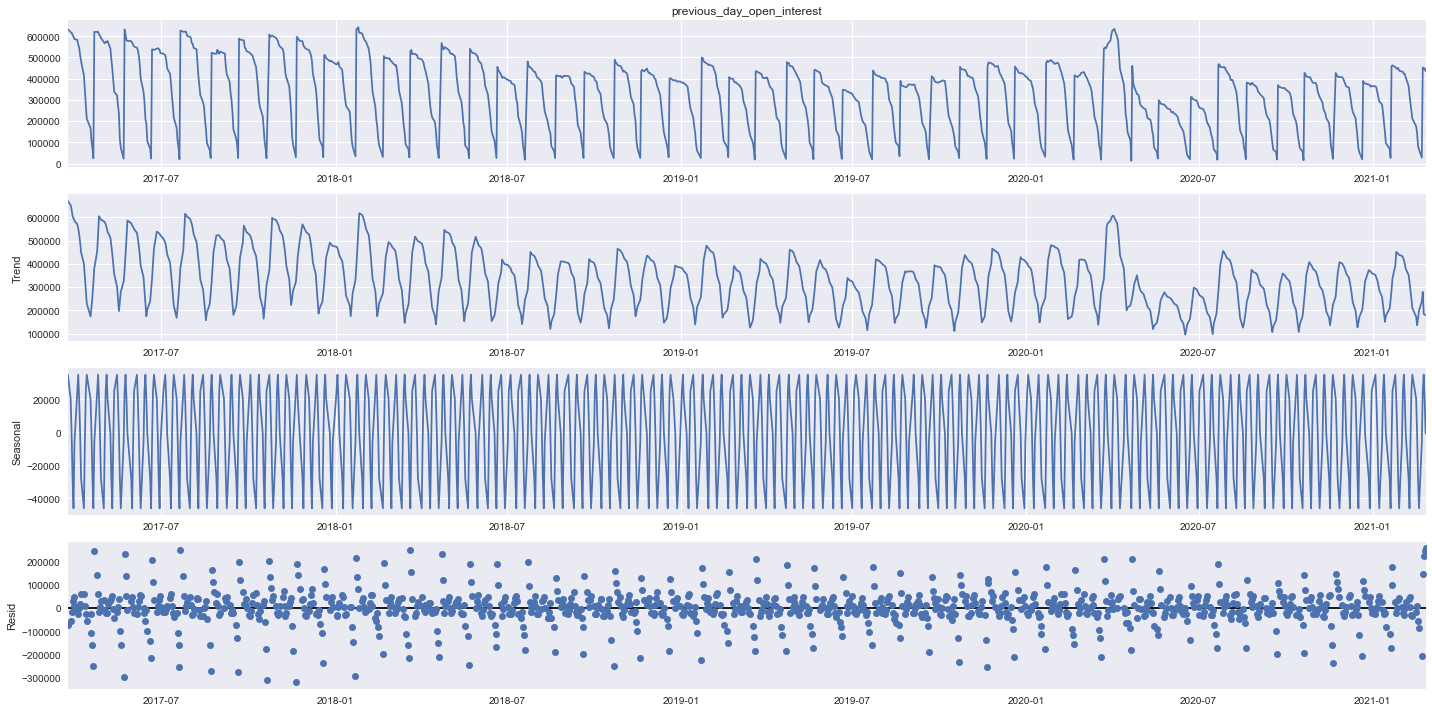

In [215]:
# Decompose time-series into Trend, Seasonality and Residuals
col_list = list(df.columns)

# Choose range of interest
start = '2017-03-24'
end = '2021-02-26'

for col_i in range(len(df.columns)):
    series = df.loc[start:end, col_list[col_i]]
    decomposed = sm.tsa.seasonal_decompose(series, model = 'additive', period=7, extrapolate_trend='freq')
    plt.rc("figure", figsize=(20,10))
    fig = decomposed.plot()
    plt.grid()
    
    # Three time-series components
    trend = decomposed.trend
    seasonal = decomposed.seasonal
    # residuals = [ Observed - (trend + seasonality) ]
    residual = decomposed.resid

> *Observations*
>
> With the data decomposed, mobility trends are noticeably short lived. A consistent downward trend is evident, for all indicators other than the increasing-residential and the steady-workplace indicators, from October 2020 through January 2021 (most recent 4 months). The seasonal aspect of the data may or may not be statistically significant, but a more conservative approach handling suggested seasonality may be apropriate. In particular, the Workplaces and Residential Mobilities may benefit from seasonal adjustment with differencing

## Time Series Stationarity


[[ go back to the top ]](#Table-of-contents)

__Check if the time series is stationarity or not:__

1. __Rolling Statistics__: Plot the moving average & moving variance, check if either vary in time.

2. __Augmented Dickey-Fuller Test:__ A statistical test for checking stationarity.
  - Null Hypothesis (H0): the time-series is NON-stationary. <br>
  - Alternate Hypothesis (H1): Reject H0, the time-series is STATIONARY.
> p-value >  threshold: FAIL to reject H0, data is NON-stationary. <br>
> p-value<= threshold: Reject H0, the data is STATIONARY.

NOTE: Most commonly: Threshold = 0.05

Reference: https://otexts.com/fpp2/stationarity.html

In [216]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    roll_mean = timeseries.rolling(window=10).mean()
    roll_std = timeseries.rolling(window=10).std()
    #Plot rolling statistics:
    plt.figure(figsize = (20,5))
    obs = plt.plot(timeseries, color='blue', label= f'Indicator: {col_list[col_i]}')
    rmean = plt.plot(roll_mean, color='red', label='Rolling-Mean')
    rstd = plt.plot(roll_std, color='black', label = 'Rolling-Stdev')
    # Formatting
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.ylabel('Index Value')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print (f'Dickey-Fuller Test Results: {col_list[col_i]}')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags Used','# Observations Used'])
    for key, val in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = val
    print (dfoutput)
    print()

In [217]:
col_list = list(work_diff.columns)
for col_i in range(len(col_list)):
    test_stationarity(work_diff[col_list[col_i]])

NameError: name 'work_diff' is not defined

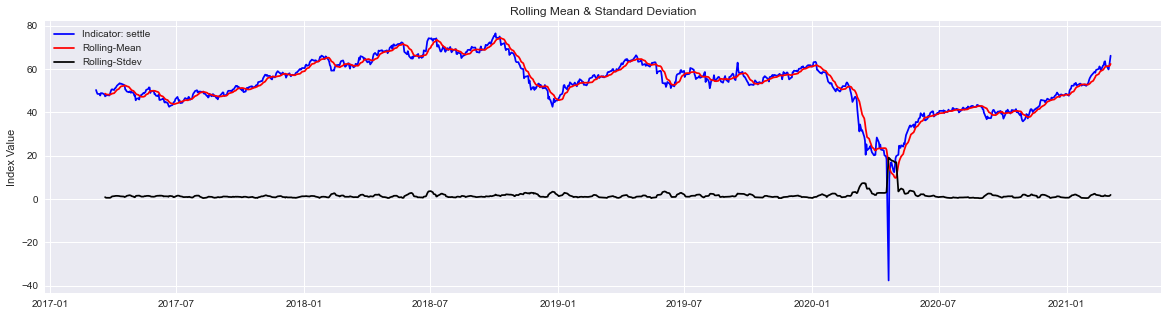

Dickey-Fuller Test Results: settle
Test Statistic           -1.962452
p-value                   0.303275
# Lags Used              11.000000
# Observations Used     995.000000
Critical Value (1%)      -3.436939
Critical Value (5%)      -2.864449
Critical Value (10%)     -2.568319
dtype: float64



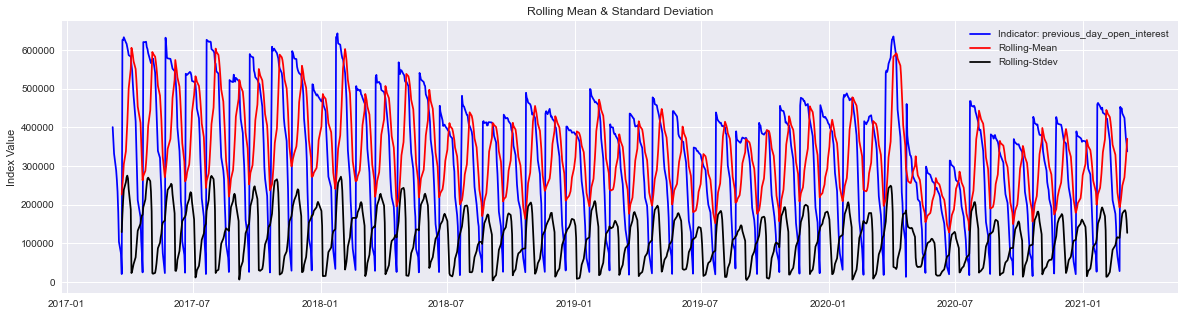

Dickey-Fuller Test Results: previous_day_open_interest
Test Statistic           -2.790096
p-value                   0.059702
# Lags Used              22.000000
# Observations Used     984.000000
Critical Value (1%)      -3.437013
Critical Value (5%)      -2.864482
Critical Value (10%)     -2.568336
dtype: float64



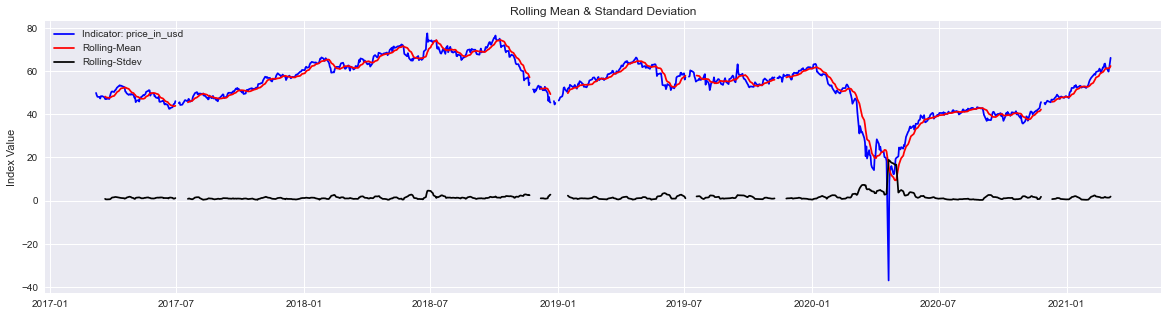

Dickey-Fuller Test Results: price_in_usd


MissingDataError: exog contains inf or nans

In [218]:
col_list = list(df.columns)
for col_i in range(len(list(df.columns))):
    test_stationarity(df[col_list[col_i]])

> **Insights**
>
> Without further processing, the trends in retail, grocery, transit, and parks mobilities are not stationary. This is identified by the observable trends in rolling 10-day means(red) and acceptance of the "Dickey-Fuller H0's" that the mobility indicators are not stationary(p-value > 0.05). In particular, H0 is rejected for mobility trends around workplaces and places of residence (p-value < 0.05). Additionally, each mobility indicator seems to have a relatively steady variance indicating that the time-series interactions between trend, seasonality, and residual are additive.

## Making Time Series Stationary

### Differencing

[[ go back to the top ]](#Table-of-contents)

In [219]:
# Create a differenced series
def difference(dataset, interval = 1):
    difference = dataset-dataset.shift(interval)
        
    return difference.dropna(inplace= False)

In [220]:
# Seasonal adjustment with differencing
X = df.workplaces.copy()
diff = []
days_in_week = 7
for i in range(days_in_week, len(X)):
    # Differencing by one-week (7 days)
    value = X[i] - X[i - days_in_week]
    items = (str(X.index[i]), value)
    diff.append(items)
work_diff = pd.DataFrame(diff, columns = ['date', 'workplaces_season7'])
work_diff['date'] = pd.to_datetime(work_diff['date'])
work_diff.set_index('date', inplace = True)
plt.plot(work_diff)
plt.title('Workplaces Mobility: 7-Day Seasonally Adjusted differencing')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'workplaces'

#### DJTA Differencing

In [221]:
df_differenced = difference(df[['dow_jones_transportation_average']])
plt.figure(figsize=(20,5))
plt.plot(df_differenced)
plt.grid()
test_stationarity(df_differenced)

KeyError: "None of [Index(['dow_jones_transportation_average'], dtype='object')] are in the [columns]"

In [222]:
# Decompose time-series into Trend, Seasonality and Residuals
col_list = list(df_differenced.columns)
for col_i in range(len(df_differenced.columns)):
    decomposed = sm.tsa.seasonal_decompose(df_differenced[col_list[col_i]],
                                           model = 'additive',
                                           period = 5,
                                           extrapolate_trend='freq')
    plt.rc("figure", figsize=(20,10))
    fig = decomposed.plot()
    plt.grid()
    
    # Three time-series components
    trend = decomposed.trend
    seasonal = decomposed.seasonal
    # residuals = [ Observed - (trend + seasonality) ]
    residual = decomposed.resid

NameError: name 'df_differenced' is not defined

## Autocorrelations and Partial Autocorrelations

[[ go back to the top ]](#Table-of-contents)

In [223]:
## Calculate the ACF and PACF for the flow series up to 20 lags
#df_sub = df[['workplaces']]
# acf_20 = acf(df_sub, nlags=20)
# pacf_20 = pacf(df_sub, nlags=20)
def ACF_PACF_diff(timeseries_df):
    # Draw Plot
    fig, axs = plt.subplots(nrows = 2,
                            ncols = 2,
                            figsize=(20,10),
                            dpi= 100,
                            sharex = True,
                            sharey = True)

    ts = timeseries_df
    plot_acf(ts, lags=20, ax=axs[0][0])
    plot_pacf(ts, lags=20, ax=axs[0][1])

    ts_diff = difference(ts)
    plot_acf(ts_diff, lags=20, ax=axs[1][0])
    plot_pacf(ts_diff, lags=20, ax=axs[1][1])
    axs[1][0].title.set_text('Autocorrelation-Differenced')
    axs[1][1].title.set_text('Partial Autocorrelation-Differenced')
    plt.suptitle(f'{ts.columns[0]} Mobility'.upper(), fontsize = 20)
    return
    #plt.show()

In [224]:
ACF_PACF_diff(df[['dow_jones_transportation_average']])

KeyError: "None of [Index(['dow_jones_transportation_average'], dtype='object')] are in the [columns]"

> *Observations*
>
> Large-positive values for small lags suggest evidence of a trend and a "weekly seasonality" is obviously present in both the non-differenced and the differenced data.

In [225]:
ACF_PACF_diff(df_differenced)

NameError: name 'df_differenced' is not defined

> *Observations*
>
> For "Workplace Mobility", the Seasonally-adjusted series' autocorrelations are significant for several lags. The PACF plot has significant spikes only at Lags-1, 7 & 8, therefore all the higher-order autocorrelations are effectively explained by the Lag-1 and weekly lags. We will add these(L-1, L-7, L-8) autocorrelation terms to the forecasting equation.<br>
>* SARIMAX: Include L-1 ( p=[1], d=1, q ) and L-7 (P, D=0, Q, s=7)
>* Maybe include L-2 ( p=[2], d=1, q ) or both L-1 and L-2 ( p=2, d=1, q )
>* Try q, Q =[0,1,2]

### ARIMA Modeling

[[ go back to the top ]](#Table-of-contents)

In [226]:
df_differenced

NameError: name 'df_differenced' is not defined

KeyError: "None of [Index(['dow_jones_transportation_average'], dtype='object')] are in the [columns]"

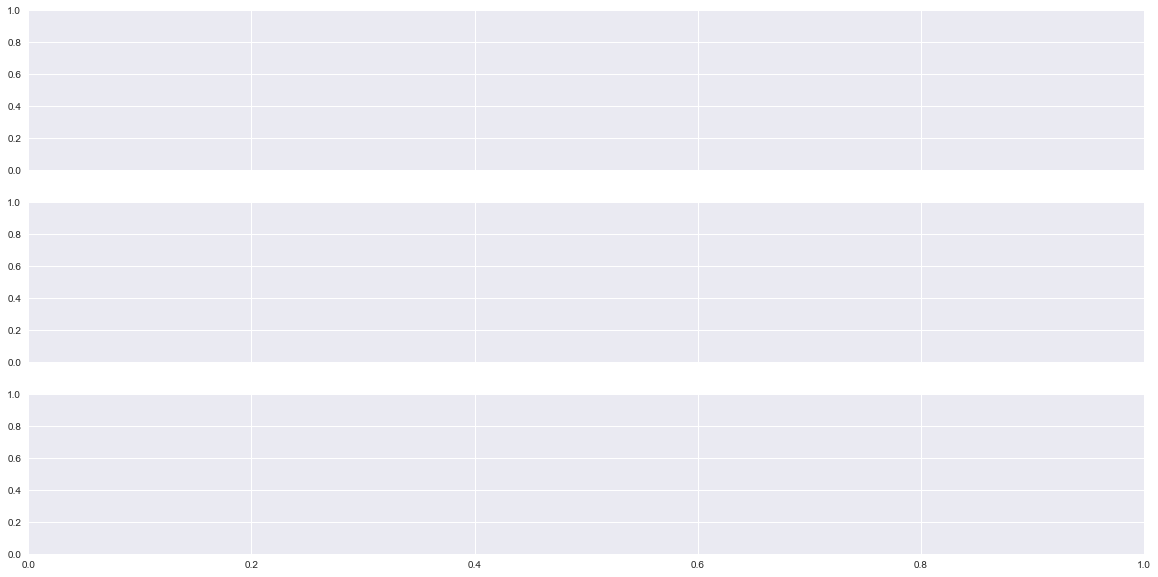

In [227]:
fig, ax = plt.subplots(nrows = 3,
                       ncols = 1,
                       figsize=(20,10), 
                       sharex = True)

df_sub = df[['dow_jones_transportation_average']]

# Element-wise subtraction w/ a Series, for set_title("RSS")
df_diff = df_differenced.dow_jones_transportation_average

fsize = 15
p = 5; d = 1; q = 1

for nax in range(3):
    if nax == 0:
        # AR Model, choose "p" (p, d = 1, q = 0)
        model = ARIMA(df_sub, order=(p,d,0))
        results_AR = model.fit(disp=-1)
        ax[nax].plot(results_AR.fittedvalues, label = f'AR({p}) Predictions')
        # Residual Sum of Squares
        ax[nax].set_title(f'AR({p}) Model - RSS: %.4f'%sum((results_AR.fittedvalues - df_diff)**2),
                          fontsize = fsize)
        
    elif nax == 1:
        # MA Model, choose "q" (p = 0, d = 1, q)
        model = ARIMA(df_sub, order=(0,d,q))
        results_MA = model.fit(disp=-1)
        ax[nax].plot(results_MA.fittedvalues, label = f'MA({q}) Predictions')
        # Residual Sum of Squares
        ax[nax].set_title(f'MA({q}) Model - RSS: %.4f'%sum((results_MA.fittedvalues - df_diff)**2),
                          fontsize = fsize)
        
    elif nax == 2:
        # ARIMA model, choose "p" & "q" (p, d, q)
        model = ARIMA(df_sub, order=(p,d,q))
        results_ARIMA = model.fit(disp=-1)
        ax[nax].plot(results_ARIMA.fittedvalues, label = f'ARIMA({p},{d},{q}) Predictions')
        # Residual Sum of Squares
        ax[nax].set_title(f'ARIMA({p},{d},{q}) Model - RSS: %.4f'%sum((results_ARIMA.fittedvalues - df_diff)**2),
                          fontsize = fsize)
        
    ax[nax].plot(df_diff, label = 'Original')    
    ax[nax].legend()
    #ax[nax].set_xlabel('Timestamp')
    ax[nax].set_ylabel('Index Value', fontsize = fsize)
plt.suptitle('Dow Jones Transportation Average', y=1.05, fontsize=20)    
plt.tight_layout()

> *Insights*
>
>

## Conclusion

[[ go back to the top ]](#Table-of-contents)

In [228]:
# save DataFrame for modeling
#df.to_csv(r'../../data/Financial_Market/commodity_stationary.csv', index = True)

df

In [ ]:
df